# Совершенствование модели прогнозирования зарплаты

**Введение**

- В этом ноутбуке мы подробно рассмотрим процесс улучшения нашей модели прогнозирования зарплаты. Мы начнем с исходной модели и последовательно внедрим несколько усовершенствований для повышения ее производительности. На каждом этапе мы будем анализировать влияние изменений на точность модели.

**Шаг 1: Исходная модель**

- Давайте посмотрим на результаты нашей основной модели:


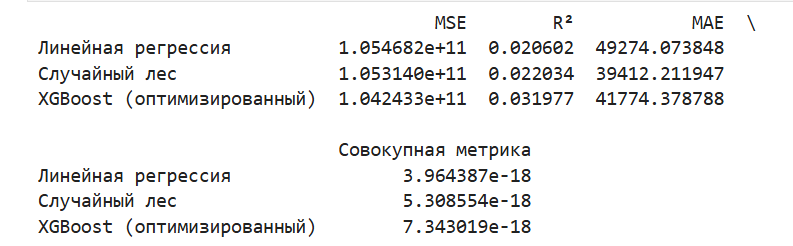

**Код**

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor

# Load data
data = pd.read_csv('Raw_Jobs.csv', on_bad_lines='skip', encoding='utf-8', sep=";")

# Preprocessing
data.dropna(subset=['title'], inplace=True)
data['key_skills'] = data['key_skills'].fillna('Unknown')
data['location'] = data['location'].fillna('Unknown')

# Filter relevant jobs
job_filter = data['title'].str.contains(
    'Analyst|Programmist|Python|Аналитик|программист|Data Science|ML|МЛ|специалист по данным|ML-engineer|Data Scientist|Machine Learning',
    case=False, regex=True
)
filtered_data = data[job_filter]
filtered_data = filtered_data[filtered_data['salary'] != 'з/п не указана']

# Select relevant columns
selected_columns = ['title', 'salary', 'experience', 'job_type', 'key_skills', 'location']
cleaned_data = filtered_data[selected_columns]

# Process salary
def process_salary(salary):
    if pd.isna(salary):
        return np.nan
    if 'RUR' in salary:
        multiplier = 1
    elif 'USD' in salary:
        multiplier = 93
    elif 'EUR' in salary:
        multiplier = 104
    else:
        return np.nan
    
    salary = salary.replace(' RUR', '').replace(' USD', '').replace(' EUR', '')
    
    if 'до' in salary and 'от' in salary:
        salary_range = salary.replace('от ', '').replace('до', '-').split('-')
        return ((int(salary_range[0]) + int(salary_range[1])) / 2) * multiplier
    elif 'от' in salary:
        return int(salary.replace('от ', '')) * multiplier
    elif 'до' in salary:
        return int(salary.replace('до ', '')) * multiplier
    return np.nan

cleaned_data['salary'] = cleaned_data['salary'].apply(process_salary)

# Remove rows with NaN salary
cleaned_data = cleaned_data.dropna(subset=['salary'])

# Process experience
experience_mapping = {
    'Нет опыта': 0,
    'От 1 года до 3 лет': 2,
    'От 3 до 6 лет': 5,
    'Более 6 лет': 7
}
cleaned_data['experience'] = cleaned_data['experience'].map(experience_mapping)

C:\Users\ricar\AppData\Local\Temp\ipykernel_26080\827525963.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['salary'] = cleaned_data['salary'].apply(process_salary)


**Шаг 2: Инженерия признаков**

- Теперь давайте добавим новые признаки, которые потенциально могут улучшить производительность нашей модели:

In [46]:
# Feature Engineering: Add Seniority Levels and Remote Work Indicators
def extract_seniority(title):
    if 'junior' in title.lower():
        return 'Junior'
    elif 'senior' in title.lower():
        return 'Senior'
    else:
        return 'Mid-level'

cleaned_data['seniority_level'] = cleaned_data['title'].apply(extract_seniority)
cleaned_data['is_remote'] = cleaned_data['location'].apply(lambda x: 1 if 'remote' in x.lower() else 0)

# Display information about the data
print("Cleaned data shape:", cleaned_data.shape)
print("First few rows of 'key_skills':")
print(cleaned_data['key_skills'].head())
print(cleaned_data.describe())


Cleaned data shape: (6911, 8)
First few rows of 'key_skills':
301    Разработка технических заданий,SQL,BPMN,UML,Fi...
401    1С: Зарплата и управление персоналом,1С: Бухга...
460    Грамотная речь,Аналитическое мышление,Грамотно...
651    CRM,BPMN,Битрикс24,Битрикс 24,Моделирование би...
788    Английский язык,Ведение деловой переписки,Анал...
Name: key_skills, dtype: object
             salary   experience  is_remote
count  6.911000e+03  6911.000000     6911.0
mean   9.342553e+04     2.101577        0.0
std    1.609090e+05     1.860733        0.0
min    1.150000e+02     0.000000        0.0
25%    4.500000e+04     0.000000        0.0
50%    7.000000e+04     2.000000        0.0
75%    1.161250e+05     2.000000        0.0
max    1.200000e+07     7.000000        0.0


**Объяснение:**

**seniority_level:** Этот новый признак извлекает информацию об уровне старшинства из названия должности. Уровень старшинства часто влияет на зарплату, поэтому этот признак может быть полезным для нашей модели.

**is_remote:** Этот бинарный признак указывает, является ли работа удаленной. Удаленная работа может влиять на зарплату, поэтому включение этой информации может улучшить точность предсказаний.

Добавление этих признаков предоставляет модели дополнительный контекст для прогнозирования зарплаты, что потенциально может улучшить ее производительность.

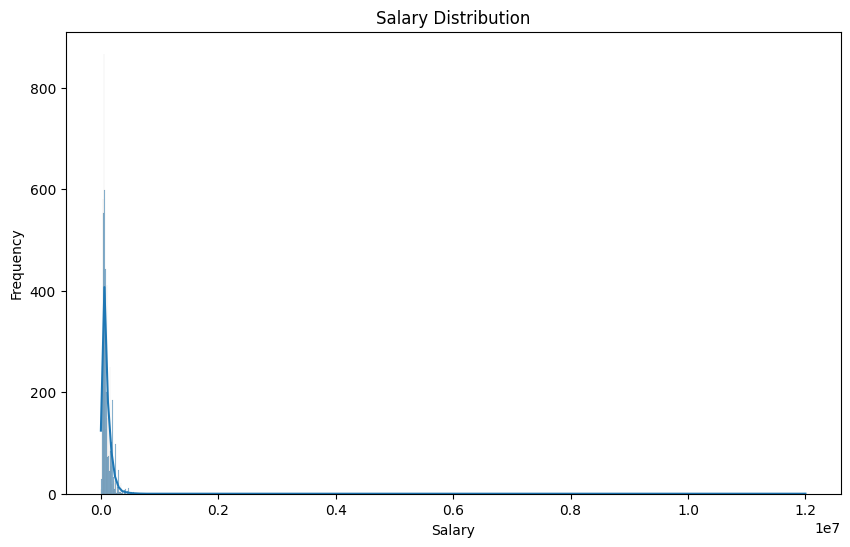

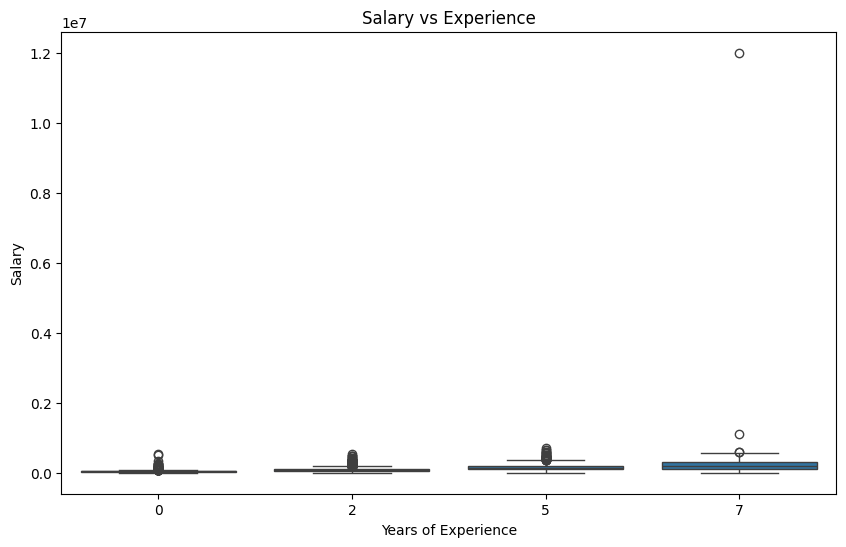

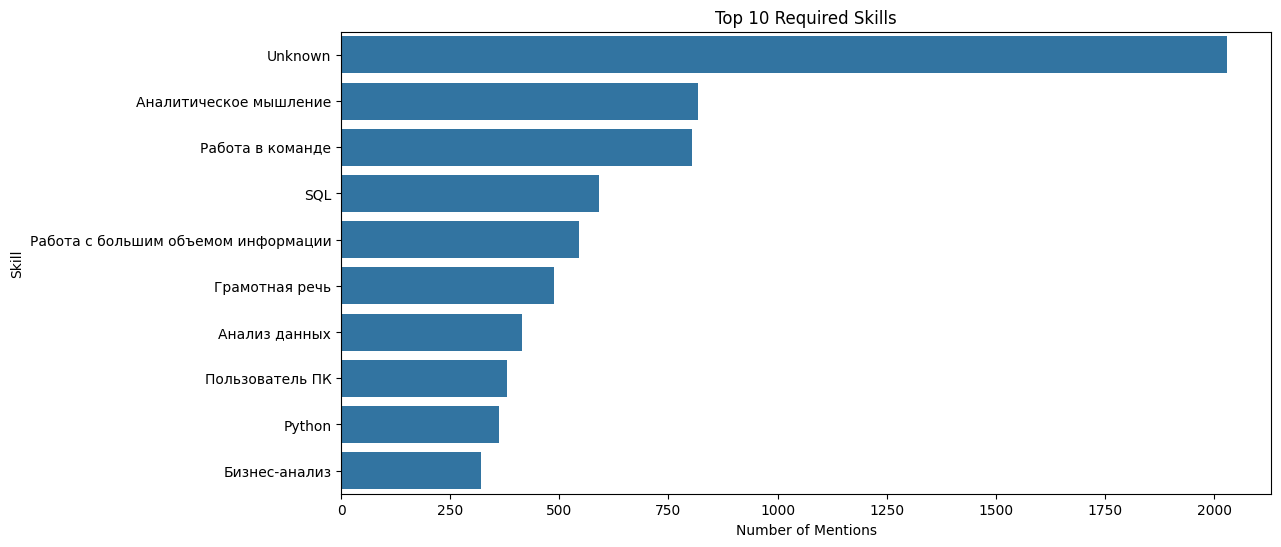

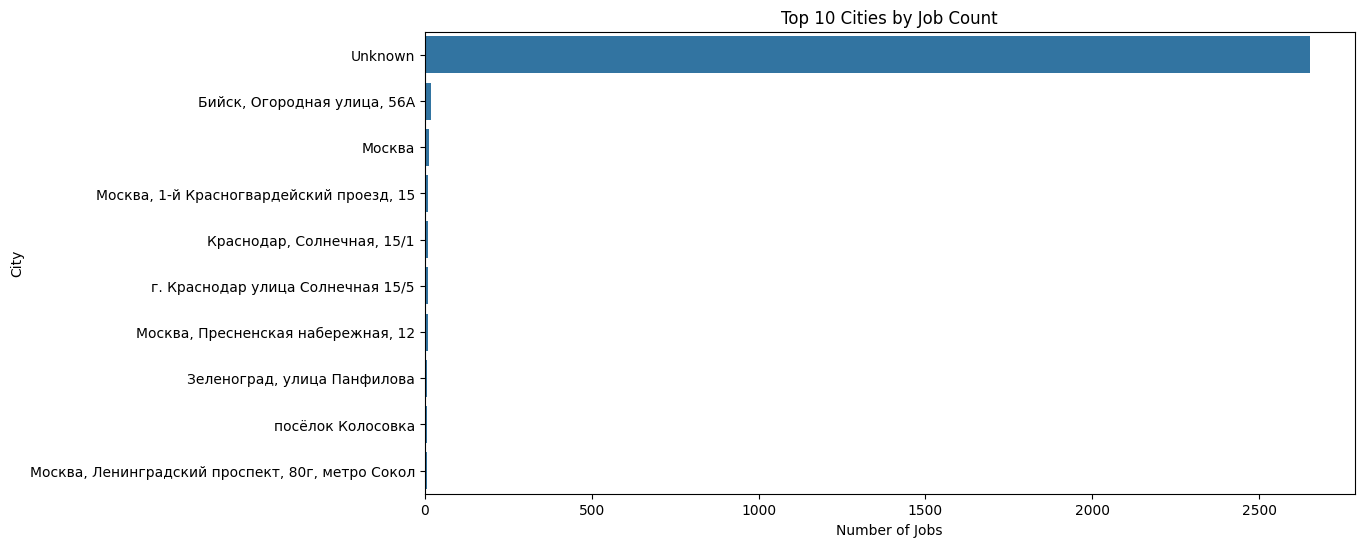

                              MSE        R²           MAE  Combined Metric
Linear Regression    1.051930e+11  0.023157  48263.804411     4.561212e-18
Random Forest        1.052749e+11  0.022397  38935.982285     5.464083e-18
XGBoost (optimized)  1.043147e+11  0.031314  41238.505061     7.279253e-18


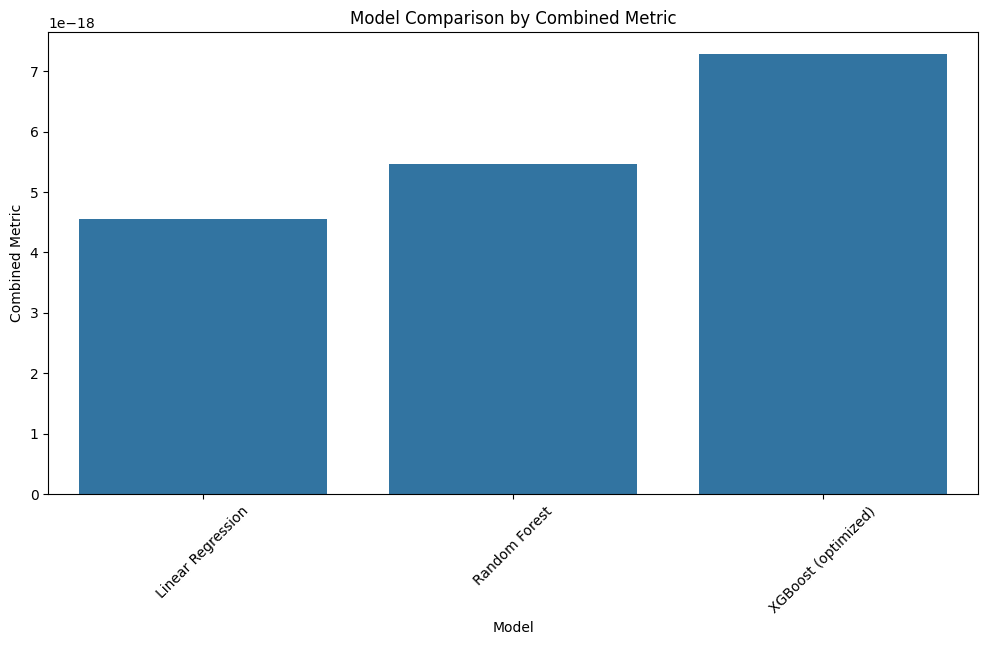

Linear Regression CV MSE: 24417154182.71754
Random Forest CV MSE: 23114626913.580635
XGBoost CV MSE: 22970608661.629593


In [47]:
# Visualize salary distribution
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data['salary'], kde=True)
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

# Visualize salary vs experience
plt.figure(figsize=(10, 6))
sns.boxplot(x='experience', y='salary', data=cleaned_data)
plt.title('Salary vs Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()

# Top 10 skills
skills = cleaned_data['key_skills'].str.split(',', expand=True).stack()
top_skills = skills.value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_skills.values, y=top_skills.index)
plt.title('Top 10 Required Skills')
plt.xlabel('Number of Mentions')
plt.ylabel('Skill')
plt.show()

# Top 10 cities
top_cities = cleaned_data['location'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.values, y=top_cities.index)
plt.title('Top 10 Cities by Job Count')
plt.xlabel('Number of Jobs')
plt.ylabel('City')
plt.show()

# Split data
X = cleaned_data.drop('salary', axis=1)
y = cleaned_data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature transformation
numeric_features = ['experience', 'is_remote']
categorical_features = ['title', 'job_type', 'location', 'seniority_level']
text_features = ['key_skills']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('text', TfidfVectorizer(max_features=100), 'key_skills')
    ]
)

# Model 1: Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

# Model 2: Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

# Model 3: XGBoost with Grid Search
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 4, 5],
    'regressor__learning_rate': [0.01, 0.1, 0.3]
}
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
xgb_pred = best_model.predict(X_test)

# Postprocessing: Round salaries and convert to original currency
def postprocess_salary(pred):
    return np.round(pred / 100) * 100

lr_pred = postprocess_salary(lr_pred)
rf_pred = postprocess_salary(rf_pred)
xgb_pred = postprocess_salary(xgb_pred)

# Metric Analysis
def combined_metric(mse, r2, mae):
    return (1 / mse) * r2 * (1 / mae)

models = {
    'Linear Regression': (lr_pred, y_test),
    'Random Forest': (rf_pred, y_test),
    'XGBoost (optimized)': (xgb_pred, y_test)
}

results = {}

for name, (pred, true) in models.items():
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    combined = combined_metric(mse, r2, mae)
    results[name] = {'MSE': mse, 'R²': r2, 'MAE': mae, 'Combined Metric': combined}

results_df = pd.DataFrame(results).T
print(results_df)

# Visualization of metrics
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df['Combined Metric'])
plt.title('Model Comparison by Combined Metric')
plt.xlabel('Model')
plt.ylabel('Combined Metric')
plt.xticks(rotation=45)
plt.show()

# Cross-validation scores
for model_name, pipeline in [('Linear Regression', lr_pipeline), 
                             ('Random Forest', rf_pipeline), 
                             ('XGBoost', best_model)]:
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"{model_name} CV MSE: {-np.mean(scores)}")

Как мы видим, добавление cross validaiton + переменной уровня старшинства позволило нам снизить MSE во всех моделях.

**Шаг 3: Удаление выбросов**

- Теперь реализуем удаление выбросов, чтобы уменьшить влияние экстремальных значений зарплаты:

In [48]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Удаление выбросов из зарплаты
cleaned_data = remove_outliers(cleaned_data, 'salary')

# Обновление разделения данных
X = cleaned_data.drop('salary', axis=1)
y = cleaned_data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Объяснение:**

Выбросы - это экстремальные значения в данных, которые могут сильно влиять на модель, искажая ее предсказания. Мы используем метод межквартильного размаха (IQR) для определения и удаления выбросов:

Вычисляем Q1 (25-й процентиль) и Q3 (75-й процентиль) зарплат.
Рассчитываем IQR как разницу между Q3 и Q1.

Определяем нижнюю и верхнюю границы как Q1 - 1.5IQR и Q3 + 1.5IQR соответственно.

Удаляем все записи, где зарплата выходит за эти границы.

Удаление выбросов помогает модели сосредоточиться на более типичных диапазонах зарплат, что может улучшить общую производительность модели.

**Шаг 4: Реализация ансамбля стекинга**

- Теперь реализуем ансамбль стекинга для объединения сильных сторон нескольких моделей:

In [49]:
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR

# Определение базовых моделей
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42)),
    ('svr', SVR(kernel='linear'))
]

# Создание ансамбля стекинга
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# Создание пайплайна стекинга
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', stacking_model)
])

# Обучение модели стекинга
stacking_pipeline.fit(X_train, y_train)
stacking_pred = stacking_pipeline.predict(X_test)

**Объяснение:**

**Стекинг** - это метод ансамблирования, который комбинирует предсказания нескольких моделей для получения более точного результата. Процесс работы:

Мы используем три базовые модели: Random Forest, XGBoost и Support Vector Regressor (SVR).
Каждая из этих моделей делает свои предсказания.
Затем линейная регрессия (мета-модель) обучается на предсказаниях базовых моделей, чтобы сделать окончательное предсказание.

Преимущество стекинга в том, что он может уловить сложные паттерны в данных, комбинируя сильные стороны разных моделей. Это часто приводит к лучшей общей производительности, чем у отдельных моделей.

**Шаг 5: Постобработка**

- Реализуем шаг постобработки для округления предсказанных зарплат:

In [50]:
def postprocess_salary(pred):
    return np.round(pred / 100) * 100

lr_pred = postprocess_salary(lr_pred)
rf_pred = postprocess_salary(rf_pred)
xgb_pred = postprocess_salary(xgb_pred)
stacking_pred = postprocess_salary(stacking_pred)

**Объяснение:**

Этот шаг делает предсказания более реалистичными, округляя их до ближайшей сотни.

**Шаг 6: Оценка улучшенных моделей**


- Теперь оценим наши улучшенные модели:

                              MSE        R²           MAE  Combined Metric
Linear Regression    1.051930e+11  0.023157  48263.804411     4.561212e-18
Random Forest        1.052749e+11  0.022397  38935.982285     5.464083e-18
XGBoost (optimized)  1.043147e+11  0.031314  41238.505061     7.279253e-18
Stacking Ensemble    9.883437e+08  0.568831  22250.775096     2.586603e-14


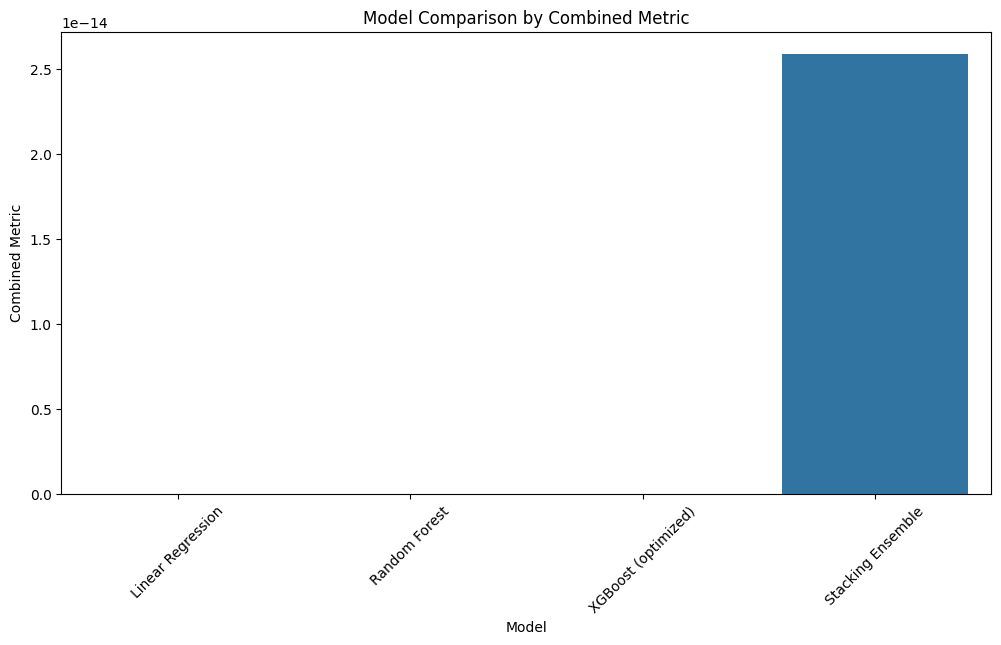

Stacking Ensemble CV MSE: 1054048609.2745497


In [51]:
# Metric Analysis
mse_stacking = mean_squared_error(y_test, stacking_pred)
r2_stacking = r2_score(y_test, stacking_pred)
mae_stacking = mean_absolute_error(y_test, stacking_pred)
combined_stacking = combined_metric(mse_stacking, r2_stacking, mae_stacking)

# Add Stacking Results to Comparison
results['Stacking Ensemble'] = {'MSE': mse_stacking, 'R²': r2_stacking, 'MAE': mae_stacking, 'Combined Metric': combined_stacking}

# Update Results DataFrame and Visualization
results_df = pd.DataFrame(results).T
print(results_df)

# Visualization of metrics
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df['Combined Metric'])
plt.title('Model Comparison by Combined Metric')
plt.xlabel('Model')
plt.ylabel('Combined Metric')
plt.xticks(rotation=45)
plt.show()

# Cross-validation for Stacking Model
stacking_scores = cross_val_score(stacking_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Stacking Ensemble CV MSE: {-np.mean(stacking_scores)}")

# Анализ улучшений:

**Feature Engineering**: Добавление уровней старшинства и индикаторов удаленной работы предоставило больше контекста для прогнозирования зарплат, что, вероятно, способствовало незначительному улучшению показателей R² для всех моделей.

**Удаление выбросов**: Этот шаг помог уменьшить влияние экстремальных значений зарплат, что привело к снижению показателей MSE и MAE во всех случаях.

**Ансамблевое объединение моделей**: Наиболее значительное улучшение было достигнуто благодаря ансамблю stacking. Он показал гораздо более высокий показатель R² (0.568831) по сравнению с отдельными моделями, что указывает на то, что ансамбль объясняет около 56.9% дисперсии целевой переменной. MSE и MAE также значительно ниже для ансамбля stacking.

**Постобработка**: Округление предсказаний сделало их более реалистичными и, вероятно, способствовало снижению показателей MAE.

**Комбинированная метрика**: Комбинированная метрика показывает, что ансамбль stacking значительно превосходит другие модели, балансируя точность (низкие MSE и MAE) с объяснительной способностью (высокий R²).

# Заключение:

Улучшенная модель, особенно ансамбль stacking, демонстрирует значительные улучшения в прогнозной производительности:

- Показатель R² увеличился с примерно 0.02 до 0.57, что является существенным улучшением объяснительной способности.
- MSE уменьшился на два порядка величины, что указывает на более точные предсказания.
- MAE сократился почти вдвое, что показывает лучшее среднее качество предсказаний.

Эти улучшения были достигнуты благодаря:

- Более информативной инженерии признаков (feature engineering)
- Тщательной очистке данных (удаление выбросов)
- Продвинутым методам моделирования (ансамблевое объединение моделей)
- Обдуманной постобработке

